In [1]:
import json
import random
from tqdm import tqdm
import numpy as np

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

# Что делать?
Где есть пометка # CODE писать код

[Полезный туториал](http://jalammar.github.io/illustrated-word2vec/)

# Загружаем данные
Они уже обработанные и токенизированные. Процесс можно посмотреть в тетрадке 1.1 Processing corpus

In [2]:
with open('processed_corpus.json') as f:
    corpus = json.load(f)

In [3]:
len(corpus)

100000

In [4]:
for text in corpus[:5]:
    print(' '.join(text))

второй UNK год окончательно разочаровать решить податься альфабанк
вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит
притом ситуация решиться участие течение сутки заявить
мой ##число летний жизнь это самый неповоротливый работник банк который видеть
везде написать вклад принимать очередь это


# CBOW

In [11]:
sample_text = corpus[0]

In [12]:
' '.join(sample_text)

'второй UNK год окончательно разочаровать решить податься альфабанк'

# Реализуйте разделение предложения на примеры методом CBOW

In [13]:
def cbow_split(tokens, window, pad_token='PAD'):

    splits = []

    # CODE
    tokens = [pad_token for _ in range(window)] + tokens + [pad_token for _ in range(window)]
    for i in range(window, len(tokens) - window ):
        token = tokens[i - window: i + window + 1]
        cur_token = [token[0: window], token[window], token[window + 1:]]
        splits.append(cur_token)

    return splits

In [14]:
splits = cbow_split(sample_text, window=2)

In [15]:
for sample in splits:
    print('Левый контекст:', sample[0])
    print('Центральное слово:', sample[1])
    print('Правый контекст:', sample[2], end='\n\n')

Левый контекст: ['PAD', 'PAD']
Центральное слово: второй
Правый контекст: ['UNK', 'год']

Левый контекст: ['PAD', 'второй']
Центральное слово: UNK
Правый контекст: ['год', 'окончательно']

Левый контекст: ['второй', 'UNK']
Центральное слово: год
Правый контекст: ['окончательно', 'разочаровать']

Левый контекст: ['UNK', 'год']
Центральное слово: окончательно
Правый контекст: ['разочаровать', 'решить']

Левый контекст: ['год', 'окончательно']
Центральное слово: разочаровать
Правый контекст: ['решить', 'податься']

Левый контекст: ['окончательно', 'разочаровать']
Центральное слово: решить
Правый контекст: ['податься', 'альфабанк']

Левый контекст: ['разочаровать', 'решить']
Центральное слово: податься
Правый контекст: ['альфабанк', 'PAD']

Левый контекст: ['решить', 'податься']
Центральное слово: альфабанк
Правый контекст: ['PAD', 'PAD']



In [16]:
splits

[[['PAD', 'PAD'], 'второй', ['UNK', 'год']],
 [['PAD', 'второй'], 'UNK', ['год', 'окончательно']],
 [['второй', 'UNK'], 'год', ['окончательно', 'разочаровать']],
 [['UNK', 'год'], 'окончательно', ['разочаровать', 'решить']],
 [['год', 'окончательно'], 'разочаровать', ['решить', 'податься']],
 [['окончательно', 'разочаровать'], 'решить', ['податься', 'альфабанк']],
 [['разочаровать', 'решить'], 'податься', ['альфабанк', 'PAD']],
 [['решить', 'податься'], 'альфабанк', ['PAD', 'PAD']]]

# Expected

```python
[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]
```

In [17]:
cbow_split(sample_text, window=3)

[[['PAD', 'PAD', 'PAD'], 'второй', ['UNK', 'год', 'окончательно']],
 [['PAD', 'PAD', 'второй'], 'UNK', ['год', 'окончательно', 'разочаровать']],
 [['PAD', 'второй', 'UNK'], 'год', ['окончательно', 'разочаровать', 'решить']],
 [['второй', 'UNK', 'год'],
  'окончательно',
  ['разочаровать', 'решить', 'податься']],
 [['UNK', 'год', 'окончательно'],
  'разочаровать',
  ['решить', 'податься', 'альфабанк']],
 [['год', 'окончательно', 'разочаровать'],
  'решить',
  ['податься', 'альфабанк', 'PAD']],
 [['окончательно', 'разочаровать', 'решить'],
  'податься',
  ['альфабанк', 'PAD', 'PAD']],
 [['разочаровать', 'решить', 'податься'], 'альфабанк', ['PAD', 'PAD', 'PAD']]]

# Expected

```python
[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]
```

# Skipgram

In [18]:
' '.join(sample_text)

'второй UNK год окончательно разочаровать решить податься альфабанк'

# Реализуйте разделение предложения на примеры методом Skipgram

In [19]:
def skipgram_split(tokens, window):

    splits = []

    # CODE
    for i in range(len(tokens)):
        cur_token = tokens[i]
        token = tokens[max(0, i - window): i] + tokens[i + 1: min(i + window + 1, len(tokens))]
        for j in token:
            splits.append((j, cur_token))

    return splits

In [20]:
splits = skipgram_split(sample_text, window=2)

In [21]:
for sample in splits:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: UNK
Центральное слово: второй

Контекст: год
Центральное слово: второй

Контекст: второй
Центральное слово: UNK

Контекст: год
Центральное слово: UNK

Контекст: окончательно
Центральное слово: UNK

Контекст: второй
Центральное слово: год

Контекст: UNK
Центральное слово: год

Контекст: окончательно
Центральное слово: год

Контекст: разочаровать
Центральное слово: год

Контекст: UNK
Центральное слово: окончательно

Контекст: год
Центральное слово: окончательно

Контекст: разочаровать
Центральное слово: окончательно

Контекст: решить
Центральное слово: окончательно

Контекст: год
Центральное слово: разочаровать

Контекст: окончательно
Центральное слово: разочаровать

Контекст: решить
Центральное слово: разочаровать

Контекст: податься
Центральное слово: разочаровать

Контекст: окончательно
Центральное слово: решить

Контекст: разочаровать
Центральное слово: решить

Контекст: податься
Центральное слово: решить

Контекст: альфабанк
Центральное слово: решить

Контекст: разочароват

In [22]:
skipgram_split(sample_text, window=2)

[('UNK', 'второй'),
 ('год', 'второй'),
 ('второй', 'UNK'),
 ('год', 'UNK'),
 ('окончательно', 'UNK'),
 ('второй', 'год'),
 ('UNK', 'год'),
 ('окончательно', 'год'),
 ('разочаровать', 'год'),
 ('UNK', 'окончательно'),
 ('год', 'окончательно'),
 ('разочаровать', 'окончательно'),
 ('решить', 'окончательно'),
 ('год', 'разочаровать'),
 ('окончательно', 'разочаровать'),
 ('решить', 'разочаровать'),
 ('податься', 'разочаровать'),
 ('окончательно', 'решить'),
 ('разочаровать', 'решить'),
 ('податься', 'решить'),
 ('альфабанк', 'решить'),
 ('разочаровать', 'податься'),
 ('решить', 'податься'),
 ('альфабанк', 'податься'),
 ('решить', 'альфабанк'),
 ('податься', 'альфабанк')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [23]:
skipgram_split(sample_text, window=3)

[('UNK', 'второй'),
 ('год', 'второй'),
 ('окончательно', 'второй'),
 ('второй', 'UNK'),
 ('год', 'UNK'),
 ('окончательно', 'UNK'),
 ('разочаровать', 'UNK'),
 ('второй', 'год'),
 ('UNK', 'год'),
 ('окончательно', 'год'),
 ('разочаровать', 'год'),
 ('решить', 'год'),
 ('второй', 'окончательно'),
 ('UNK', 'окончательно'),
 ('год', 'окончательно'),
 ('разочаровать', 'окончательно'),
 ('решить', 'окончательно'),
 ('податься', 'окончательно'),
 ('UNK', 'разочаровать'),
 ('год', 'разочаровать'),
 ('окончательно', 'разочаровать'),
 ('решить', 'разочаровать'),
 ('податься', 'разочаровать'),
 ('альфабанк', 'разочаровать'),
 ('год', 'решить'),
 ('окончательно', 'решить'),
 ('разочаровать', 'решить'),
 ('податься', 'решить'),
 ('альфабанк', 'решить'),
 ('окончательно', 'податься'),
 ('разочаровать', 'податься'),
 ('решить', 'податься'),
 ('альфабанк', 'податься'),
 ('разочаровать', 'альфабанк'),
 ('решить', 'альфабанк'),
 ('податься', 'альфабанк')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [24]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)

In [25]:
len(word2index)

13076

In [26]:
word2index['UNK']

1

In [27]:
[word2index[tok] if tok in word2index else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[1282, 8436, 1]

# Torch Dataset
В торче есть очень удобная читалка данных

In [28]:
from torch.utils.data import Dataset, DataLoader

In [29]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [30]:
# соверешенно игрушечный, просто цифры
some_data_x[:10]

array([[0.83436239, 0.73507678, 0.39207538, 0.67809218],
       [0.28065868, 0.92715875, 0.71616807, 0.63624972],
       [0.5933132 , 0.9909951 , 0.77533542, 0.0025475 ],
       [0.57410596, 0.10123612, 0.126014  , 0.36636451],
       [0.86995456, 0.10574682, 0.61642667, 0.41158684],
       [0.8243191 , 0.09982818, 0.71451846, 0.58266042],
       [0.53626146, 0.68754533, 0.03817731, 0.6139604 ],
       [0.32518765, 0.90975934, 0.87879355, 0.76487795],
       [0.80799105, 0.41413144, 0.53593331, 0.85767457],
       [0.16822146, 0.36171062, 0.94817404, 0.50228764]])

In [31]:
some_data_y

array([1, 2, 1, ..., 2, 1, 2])

In [32]:
class ToyDataset(Dataset):

    def __init__(self, data_x, data_y):

        super().__init__()

        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):

        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета

        return len(self.data_x)

    def __getitem__(self, idx):

        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу

        return self.data_x[idx], self.data_y[idx]

In [33]:
some_dataset = ToyDataset(some_data_x, some_data_y)

In [34]:
some_dataset[5], some_dataset[467]

((array([0.8243191 , 0.09982818, 0.71451846, 0.58266042]), 1),
 (array([0.75927646, 0.79106565, 0.77355906, 0.36243335]), 1))

In [35]:
some_loader = DataLoader(some_dataset, batch_size=16, shuffle=True)

In [36]:
for x, y in some_loader:
    break

len(x), x

(16,
 tensor([[0.6106, 0.2990, 0.0649, 0.8751],
         [0.9776, 0.9562, 0.3991, 0.2751],
         [0.4415, 0.3696, 0.7590, 0.6289],
         [0.7267, 0.9692, 0.0930, 0.4231],
         [0.6060, 0.6164, 0.2402, 0.2034],
         [0.9147, 0.0441, 0.4910, 0.3007],
         [0.7950, 0.9899, 0.3022, 0.2614],
         [0.4984, 0.2315, 0.6833, 0.9823],
         [0.3815, 0.0946, 0.2662, 0.0154],
         [0.3134, 0.6065, 0.4250, 0.4213],
         [0.4434, 0.9414, 0.8808, 0.7463],
         [0.2225, 0.5698, 0.7278, 0.9174],
         [0.5027, 0.0639, 0.8234, 0.0282],
         [0.7019, 0.2379, 0.2923, 0.2924],
         [0.5449, 0.6582, 0.0550, 0.4030],
         [0.4438, 0.8447, 0.5779, 0.8807]], dtype=torch.float64))

In [37]:
for x, y in some_loader:
    pass

len(x)

15

In [38]:
# почему 13?
# потому что количество наших данных нацело не делится на 16
# и поэтому последний батч меньше 16-ти
len(some_dataset) % 16

15

# А зачем?

In [39]:
class ToyDataset(Dataset):

    def __init__(self, data_x, data_y):

        super().__init__()

        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):

        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета

        return len(self.data_x)

    @staticmethod
    def add_pow_features(x, n=2):

        return np.concatenate([x, x ** n])

    @staticmethod
    def add_log_features(x):

        return np.concatenate([x, np.log(x)])

    def __getitem__(self, idx):

        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу

        x = self.data_x[idx]

        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x = self.add_pow_features(x, n=2)
        x = self.add_pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x = self.add_log_features(x)

        y = self.data_y[idx]

        return x, y

In [40]:
toy_dataset = ToyDataset(some_data_x, some_data_y)

In [41]:
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [42]:
for x, y in toy_loader:
    break

In [43]:
x.shape

torch.Size([128, 32])

In [44]:
# заметим, что мы сразу получаем торчовый формат данных
x

tensor([[  0.8344,   0.7351,   0.3921,  ...,  -1.8467,  -5.6178,  -2.3308],
        [  0.2807,   0.9272,   0.7162,  ...,  -0.4538,  -2.0030,  -2.7130],
        [  0.5933,   0.9910,   0.7753,  ...,  -0.0543,  -1.5268, -35.8359],
        ...,
        [  0.3579,   0.6660,   0.8786,  ...,  -2.4387,  -0.7763,  -0.5899],
        [  0.4121,   0.5209,   0.7777,  ...,  -3.9130,  -1.5086,  -1.1104],
        [  0.0486,   0.3162,   0.2966,  ...,  -6.9075,  -7.2919,  -2.5869]],
       dtype=torch.float64)

In [45]:
y

tensor([1, 2, 1, 0, 0, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2,
        0, 1, 0, 2, 0, 1, 0, 2, 1, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 0, 0, 0, 1, 2,
        1, 1, 2, 1, 2, 1, 2, 0, 1, 0, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 0, 0,
        2, 2, 0, 2, 1, 2, 1, 0, 0, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 0, 1, 1,
        1, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 2, 1, 2, 2, 0, 1, 2, 0, 2, 0, 0, 2, 0,
        0, 2, 0, 1, 0, 0, 1, 1])

# Если вы ничего здесь не понимаете, то вернитесь в конец первой домашки, там все объясняется

In [46]:
model = torch.nn.Sequential(torch.nn.Linear(32, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 3))

criterion = torch.nn.CrossEntropyLoss()

In [47]:
with torch.no_grad():

    prediction = model(x.float())

    loss = criterion(prediction, y)

loss.item()

1.1660523414611816

# Боевые датасеты

In [48]:
class CBOWDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 pad_token='PAD',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.pad_token = pad_token
        self.pad_index = len(self.word2index)

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        splits = []

        for n in range(len(tokenized_text)):
            left_context = tokenized_text[np.maximum(n - self.window, 0):n]
            left_context = ([self.pad_index] * (self.window - len(left_context))) + left_context

            central_word = tokenized_text[n]

            right_context = tokenized_text[n + 1:n + self.window + 1]
            right_context = right_context + ([self.pad_index] * (self.window - len(right_context)))

            splits.append((left_context + right_context, central_word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            cbow_examples = self._split_function(indexed_text)

            self.data.extend(cbow_examples)

    def __getitem__(self, idx):

        context, central_word = self.data[idx]

        context = torch.Tensor(context).long()

        return context, central_word

# Мы будем учить модель Skipgram
Реализуйте читалку данных

In [56]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        # CODE

        # вставить здесь функцию, которые вы писали раньше
        splits = []
        for i in range(len(tokenized_text)):
          cur_token = tokenized_text[i]
          token = tokenized_text[max(0, i - self.window): i] + tokenized_text[i + 1: min(i + self.window + 1, len(tokenized_text))]
          for j in token:
              splits.append((j, cur_token))


        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)

            self.data.extend(skipgram_examples)

    def __getitem__(self, idx):

        # CODE
        context, central_word = self.data[idx]
        context = torch.Tensor([context, ]).long()

        return context, central_word

In [50]:
# можете положить SkipgramDataset в отдельный файлик, например word2vec_utils и относительным импортом достать его
#from .word2vec_utils import SkipgramDataset

In [57]:
dataset = SkipgramDataset(corpus, word2index)

100%|██████████| 100000/100000 [00:01<00:00, 52630.10it/s]


In [58]:
BATCH_SIZE = 512

In [59]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [60]:
for x, y in dataset_loader:
    break

In [61]:
x[:5]

tensor([[575],
        [481],
        [ 48],
        [575],
        [217]])

In [62]:
y[:5]

tensor([ 183, 1762, 2252,  727,  600])

In [63]:
x.shape, y.shape

(torch.Size([512, 1]), torch.Size([512]))

In [64]:
class CBOW(torch.nn.Module):

    def __init__(self, vocab_size, embedding_dim, pad_index):

        super().__init__()

        if pad_index > 0:
            vocab_size += 1

        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size,
                                               embedding_dim=embedding_dim,
                                               padding_idx=pad_index)

        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)

    def forward(self, x):

        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)

        return x

# Мы будем учить модель Skipgram
Реализуйте ее

In [67]:
# CODE
class SkipGram(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):

        super().__init__()

        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size,
                                               embedding_dim=embedding_dim)

        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)

    def forward(self, x):

        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)

        return x

In [ ]:
#from word2vec_utils import SkipGram

In [65]:
# размерность эмбеддинга
# маленькая, чтобы мы могли недолго поучить ворд2век и увидеть результаты
EMBEDDING_DIM = 20

In [68]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [69]:
with torch.no_grad():
    pred = model(x)

pred.shape

torch.Size([512, 13076])

In [70]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# aka loss function
criterion = torch.nn.CrossEntropyLoss()

# Допишите обучалку

In [71]:
epochs = 3

losses = []

for n_epoch in range(epochs):

    try:

        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for x, y in dataset_loader:

            # CODE

            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            # CODE

            losses.append(loss.item())

            progress_bar.set_postfix(loss=np.mean(losses[-100:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 3: 100%|██████████| 2983124/2983124 [10:04<00:00, 4936.58it/s, loss=7.65]


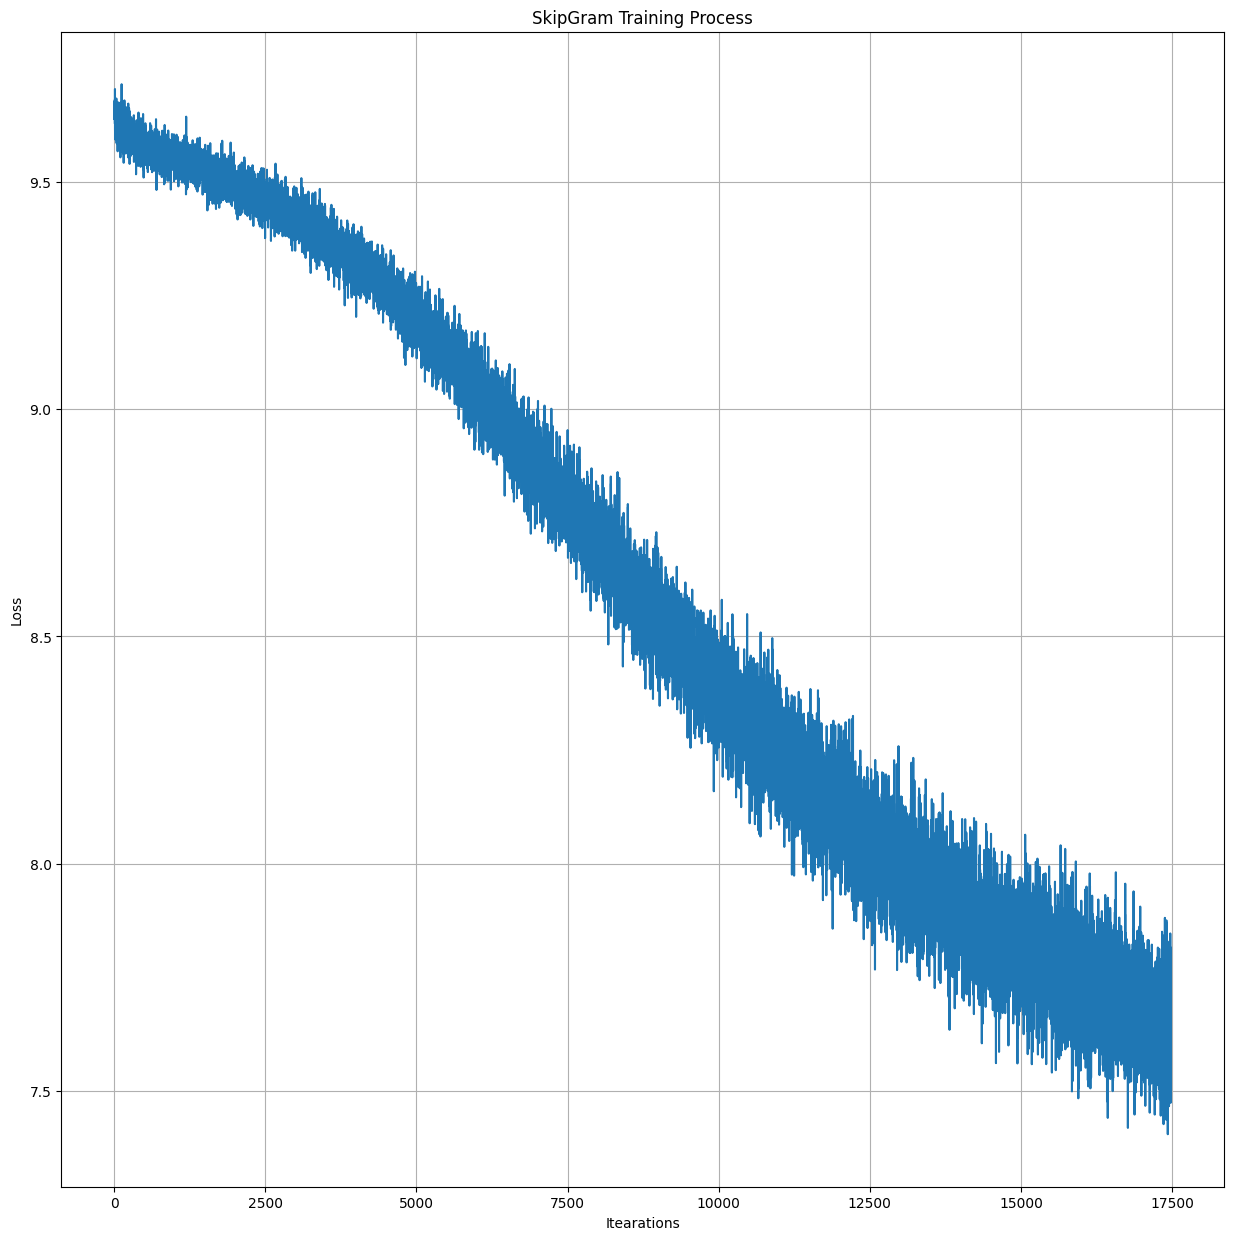

In [72]:
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [75]:
embedding_matrix = model.in_embedding.weight.detach()

In [76]:
def cos_sim(embedding_matrix, token2id, word1, word2):

    i1 = token2id[word1]
    i2 = token2id[word2]

    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]

    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))

    similarity = torch.dot(v1_n, v2_n).item()

    return similarity

# Косинусная близость
От 0 до 1, где 0 - вектора абсолютно разные, где 1 - идентичные.

In [77]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.33385908603668213

In [78]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

0.41463935375213623

In [79]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

0.44982364773750305

In [80]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.6227703094482422

In [81]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim(embedding_matrix, word2index, 'день', random_word)
'Косинусная близость слова "день" к случайному выбраному слову "{}" равна {:.3f}'.format(random_word, sim)

'Косинусная близость слова "день" к случайному выбраному слову "поискать" равна 0.363'

In [82]:
freq = {}

for text in corpus:
    for token in text:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

In [83]:
sorted_freq = [(k, freq[k]) for k in sorted(freq, key=freq.get, reverse=True)]
top_sorted_freq = sorted_freq[0:200]

In [84]:
tsne = TSNE(n_components=2, init='pca', random_state=42, verbose=2)
reduced = tsne.fit_transform(embedding_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13076 samples in 0.004s...
[t-SNE] Computed neighbors for 13076 samples in 2.366s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13076
[t-SNE] Computed conditional probabilities for sample 2000 / 13076
[t-SNE] Computed conditional probabilities for sample 3000 / 13076
[t-SNE] Computed conditional probabilities for sample 4000 / 13076
[t-SNE] Computed conditional probabilities for sample 5000 / 13076
[t-SNE] Computed conditional probabilities for sample 6000 / 13076
[t-SNE] Computed conditional probabilities for sample 7000 / 13076
[t-SNE] Computed conditional probabilities for sample 8000 / 13076
[t-SNE] Computed conditional probabilities for sample 9000 / 13076
[t-SNE] Computed conditional probabilities for sample 10000 / 13076
[t-SNE] Computed conditional probabilities for sample 11000 / 13076
[t-SNE] Computed conditional probabilities for sample 12000 / 13076
[t-SNE] Computed conditional probabilities for sam

In [85]:
top_words = [a for a,_ in top_sorted_freq]

In [86]:
inds = [word2index[word] for word in top_words]
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

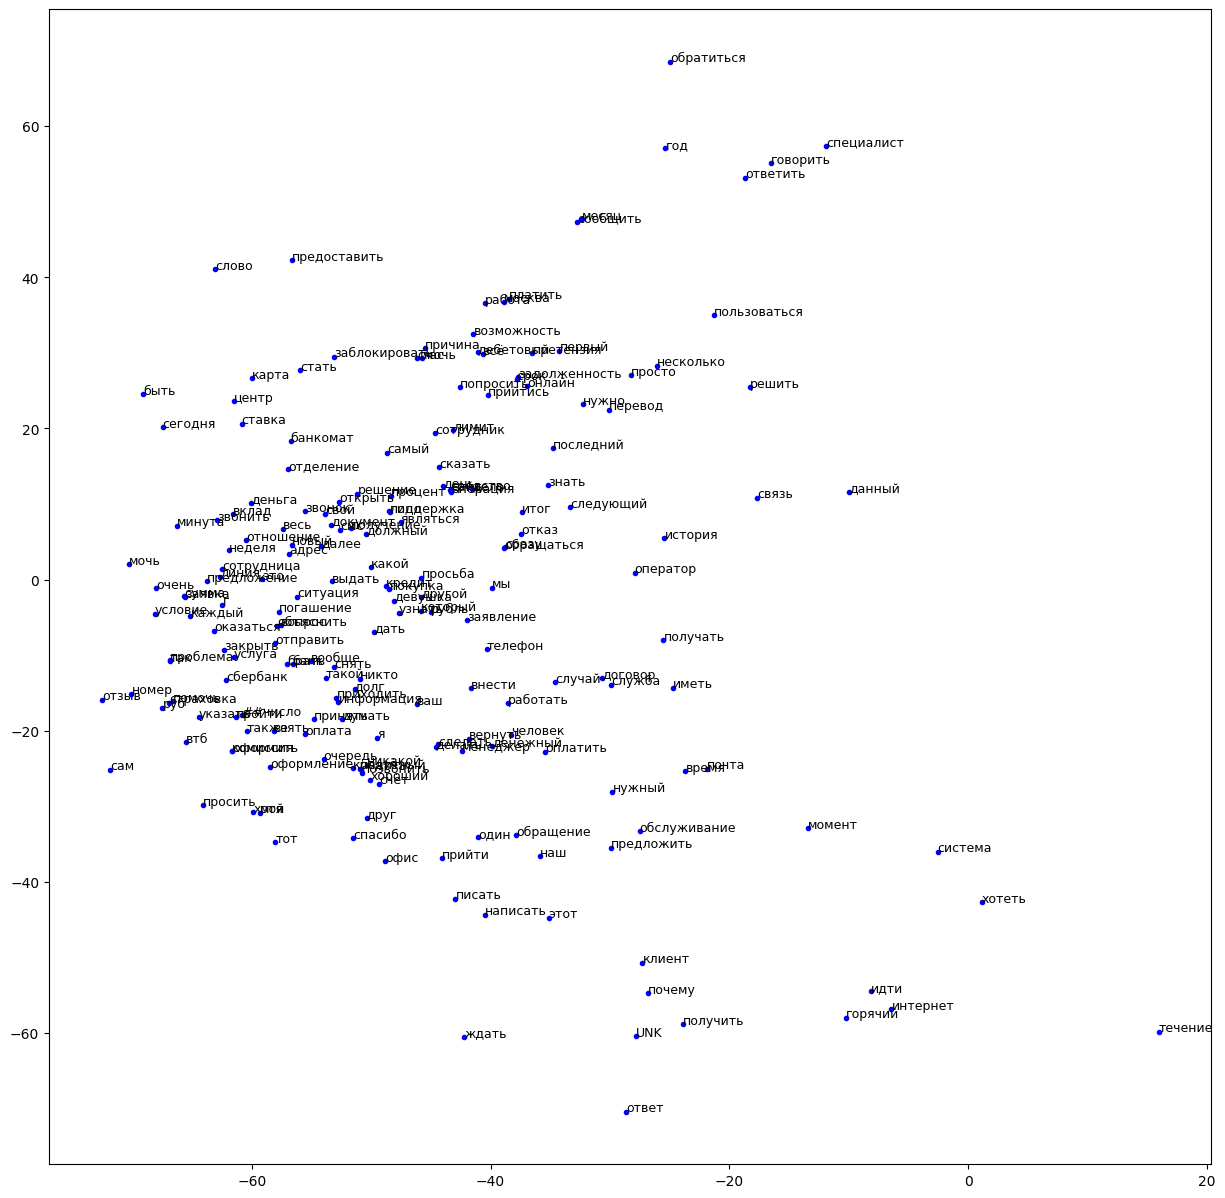

In [87]:
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.show()

# Оценка
1. Вы добрались сюда и все работает, значит уже получили 7 баллов.
2. 8 баллов - Взяли корпус для оценка качества эмбеддингов [здесь](https://rusvectores.org/static/testsets/ru_simlex965_tagged.tsv). Описание к нему [здесь](https://arxiv.org/pdf/1801.06407.pdf). Его английская версия для понимания, того что же это такое [тут](https://fh295.github.io/simlex.html). Если в кратце - он похож а гугл аналогии, просто иначе составлен. Определили качество своих эмбеддингов. Как качество измерить? Можете все значения отнормировать (привести к 1) и затем считать MSE между тем что у вас и что в оригинале.
3. 9 баллов - Поставили эксперименты, поменяли любые параметры, хоть корпус увеличили или как то почистили. Показали метрики до и после. После должно быть лучше, иначе это все еще 8 баллов.
4. 10 баллов - удивили своим подходом (или просто удивили) пока делили на 9 баллов

In [88]:
!wget https://rusvectores.org/static/testsets/ru_simlex965_tagged.tsv

--2023-11-08 19:14:26--  https://rusvectores.org/static/testsets/ru_simlex965_tagged.tsv
Resolving rusvectores.org (rusvectores.org)... 172.104.228.108
Connecting to rusvectores.org (rusvectores.org)|172.104.228.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42924 (42K) [text/tab-separated-values]
Saving to: ‘ru_simlex965_tagged.tsv’

ru_simlex965_tagged 100%[===================>]  41.92K  --.-KB/s    in 0.1s    

2023-11-08 19:14:27 (430 KB/s) - ‘ru_simlex965_tagged.tsv’ saved [42924/42924]



In [91]:
import pandas as pd
from sklearn import preprocessing

In [90]:
simlex = pd.read_csv('ru_simlex965_tagged.tsv', sep='\t')
cols = simlex.columns.tolist()
simlex.head()

,# Word1,Word2,Average Score
0,авария_NOUN,бедствие_NOUN,6.15
1,август_NOUN,месяц_NOUN,2.85
2,авиация_NOUN,полет_NOUN,6.77
3,автомобиль_NOUN,гудок_NOUN,1.85
4,автомобиль_NOUN,автострада_NOUN,1.23


In [94]:
score = simlex['Average Score'].to_numpy()
norm_score = (score - score.min()) / (score.max() - score.min())
simlex['Normalized Average Score'] = norm_score
simlex.head()

,# Word1,Word2,Average Score,Normalized Average Score
0,авария_NOUN,бедствие_NOUN,6.15,0.615
1,август_NOUN,месяц_NOUN,2.85,0.285
2,авиация_NOUN,полет_NOUN,6.77,0.677
3,автомобиль_NOUN,гудок_NOUN,1.85,0.185
4,автомобиль_NOUN,автострада_NOUN,1.23,0.123
